<a href="https://colab.research.google.com/github/sytan98/Machine-Learning-With-Tensorflow/blob/master/Ex5_Cats_v_Dogs_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [2]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2019-06-02 03:06:27--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.26.80.188, 2600:1409:3000:48e::e59, 2600:1409:3000:4a4::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.26.80.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  6.95MB/s    in 2m 3s   

2019-06-02 03:08:31 (6.38 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [0]:
# Use os.mkdir to create your directories 
# To create an entire path you have to call mkdir() once per directory level. 
# Alternatively, if you want to create multiple directories at once, make use of the makedirs() method instead
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'

try:
    os.makedirs('/tmp/cats-v-dogs/training/dogs/')
    os.makedirs('/tmp/cats-v-dogs/training/cats/')
    os.makedirs('/tmp/cats-v-dogs/testing/cats/')
    os.makedirs('/tmp/cats-v-dogs/testing/dogs/')
except OSError:
    pass

In [5]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
      file = SOURCE + filename
      if os.path.getsize(file) > 0:
          files.append(filename)
      else:
          print(filename + " is zero length, so ignoring.")
  files = [os.path.join(SOURCE, f) for f in files]
  shuffled_files = random.sample(files, len(files))
  for f in files[:int(SPLIT_SIZE*len(files))]:
      copyfile(f, os.path.join(TRAINING,os.path.basename(f)))
  for f in files[int(SPLIT_SIZE*len(files)):]:
      copyfile(f, os.path.join(TESTING, os.path.basename(f)))


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


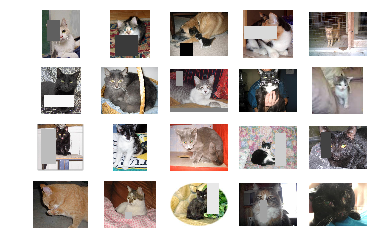

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
cols, rows = 5, 4
img_num = cols * rows


x = os.listdir('/tmp/cats-v-dogs/training/cats/')[:img_num]

eraser = get_random_eraser()

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    img = Image.open(os.path.join('/tmp/cats-v-dogs/training/cats/',x[i]))
    img = np.array(img)
    plt.imshow(eraser(img), interpolation="nearest")
    plt.axis('off')

In [7]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), input_shape = (150,150,3), activation = 'relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding = 'same'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flat

In [28]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size=50,
                                                    class_mode='binary',
                                                    target_size=(150, 150))



# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [30]:
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=2,
                              validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

Epoch 1/15


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting t

16/50 [========>.....................] - ETA: 7s - loss: 0.3531 - acc: 0.8450

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 18350080 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 6. 
  warnings.warn(str(msg))


50/50 [==============================] - 11s 230ms/step - loss: 0.3505 - acc: 0.8436
 - 169s - loss: 0.4193 - acc: 0.8033 - val_loss: 0.3505 - val_acc: 0.8436
Epoch 2/15
50/50 [==============================] - 11s 222ms/step - loss: 0.3544 - acc: 0.8444
 - 162s - loss: 0.4073 - acc: 0.8139 - val_loss: 0.3544 - val_acc: 0.8444
Epoch 3/15
50/50 [==============================] - 11s 223ms/step - loss: 0.3205 - acc: 0.8564
 - 162s - loss: 0.3932 - acc: 0.8205 - val_loss: 0.3205 - val_acc: 0.8564
Epoch 4/15
50/50 [==============================] - 11s 220ms/step - loss: 0.4330 - acc: 0.8216
 - 159s - loss: 0.3941 - acc: 0.8207 - val_loss: 0.4330 - val_acc: 0.8216
Epoch 5/15
50/50 [==============================] - 11s 219ms/step - loss: 0.3149 - acc: 0.8624
 - 159s - loss: 0.3854 - acc: 0.8251 - val_loss: 0.3149 - val_acc: 0.8624
Epoch 6/15
50/50 [==============================] - 11s 218ms/step - loss: 0.3109 - acc: 0.8676
 - 159s - loss: 0.3780 - acc: 0.8323 - val_loss: 0.3109 - val_acc

Text(0.5, 1.0, 'Training and validation loss')

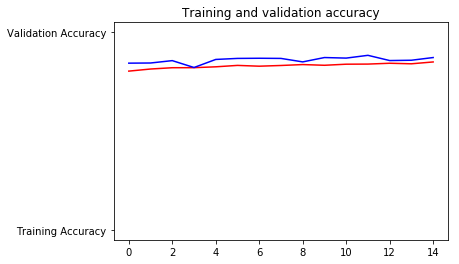

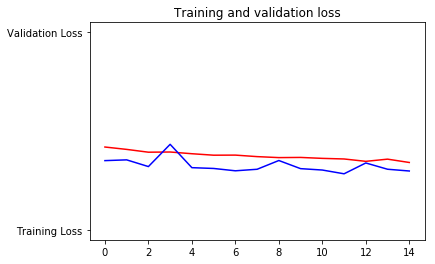

In [31]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

Using TensorFlow backend.


Saving bed-1284238_640.jpg to bed-1284238_640.jpg
[2.6522502e-34]
bed-1284238_640.jpg is a cat


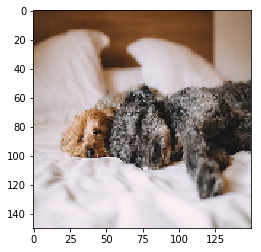

In [11]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")